In [1]:
import torch
import torch.nn as nn

import sys
import os

# Add the parent directory to the Python path
sys.path.append(os.path.abspath(os.path.join('../..')))

from models._model import CBPLTrainer

In [2]:
from utils import shape_utils

In [3]:
config = {
    "peak_regions": "/gladstone/corces/lab/users/vishvak/chrombpnet_tutorial/pd_data/Microglia_peak_set_2.bed",
    "nonpeak_regions": "/gladstone/corces/lab/users/vishvak/chrombpnet_tutorial/own_data/test.chr1.negatives.adjusted.bed",
    "genome_fasta": "/gladstone/corces/lab/users/vishvak/chrombpnet_tutorial/data/downloads/hg38.fa",
    "cts_bw_file": "/gladstone/corces/lab/users/vishvak/chrombpnet_tutorial/pd_data/nd_Microglia_merge.bw",
    "negative_sampling_ratio": 0,
    "train_size": 0.6,
    "batch_size": 32,
    "filters": 512,
    "n_dil_layers": 8,
    "conv1_kernel_size": 21,
    "profile_kernel_size": 75,
    "dilation_kernel_size": 3,
    "input_seq_len": 2214,
    "out_pred_len": 500,
    "dropout_rate": 0.0,
    "learning_rate": 0.001,
    "train_chrs": ["chr1","chr2","chr3","chr4","chr5","chr6","chr7","chr8","chr9","chr10"],
    "valid_chrs": ["chr10","chr11","chr12","chr13","chr14"],
    "seq_focus_len": 500,
    "use_cpu": False,
    "alpha" : 1,
    "checkpoint_path": None,
    "project": "cbpl_new_microglia"
}


In [4]:
trainer =  CBPLTrainer(config)

Read in bed file of 151351 regions
Read in bed file of 16900 regions
Loaded 151351 peak regions and 0 non-peak regions
Calculating average count for combined loss weight
Average count per training peak = 137645.625
cpu


/wynton/home/corces/vishvak/miniforge3/envs/chrombpnet/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028


In [5]:
for batch in trainer.train_dataloader:
    inputs, targets = batch
    break  
#outputs=trainer.model.forward_test(inputs)

In [6]:
outputs=trainer.model.forward_test(inputs)

starting size:torch.Size([32, 4, 2214])
after first convolution:torch.Size([32, 512, 2194])
after 1th dilation:torch.Size([32, 512, 2190])
after 1th crop:torch.Size([32, 512, 2190])
after 2th dilation:torch.Size([32, 512, 2182])
after 2th crop:torch.Size([32, 512, 2182])
after 3th dilation:torch.Size([32, 512, 2166])
after 3th crop:torch.Size([32, 512, 2166])
after 4th dilation:torch.Size([32, 512, 2134])
after 4th crop:torch.Size([32, 512, 2134])
after 5th dilation:torch.Size([32, 512, 2070])
after 5th crop:torch.Size([32, 512, 2070])
after 6th dilation:torch.Size([32, 512, 1942])
after 6th crop:torch.Size([32, 512, 1942])
after 7th dilation:torch.Size([32, 512, 1686])
after 7th crop:torch.Size([32, 512, 1686])
after 8th dilation:torch.Size([32, 512, 1174])
after 8th crop:torch.Size([32, 512, 1174])
Profile prediction shape: torch.Size([32, 500])
Count prediction shape: torch.Size([32, 1])


In [9]:
trainer.model.calculate_metrics(outputs,targets)

{'count_mse': 124.50648498535156,
 'count_mae': 11.131204605102539,
 'count_spearman': 0.06854839622974396,
 'profile_mse': 222706.9375,
 'profile_kl_divergence': 0.4490038752555847,
 'profile_explained_variance': -0.00010472095164004713,
 'profile_cosine_similarity': 0.7272040247917175,
 'profile_mae': 226.5405731201172,
 'profile_r2': -0.2995176315307617,
 'profile_spearman': -0.0531153604388237,
 'profile_nll': 16158.77734375}

In [7]:
trainer.model.loss(outputs,targets)

predicted counts shape = torch.Size([32, 1])
true counts shape = torch.Size([32, 1])
predicted profile shape = torch.Size([32, 500])
true profile shape = torch.Size([32, 500])


tensor(8631730., grad_fn=<AddBackward0>)

In [8]:
loss = nn.MSELoss()

In [16]:
import torch.nn.functional as F

In [17]:
F.mse_loss(outputs[1],targets[1])

tensor(197055.8906, grad_fn=<MseLossBackward0>)

In [10]:
loss(outputs[1],targets[1])

tensor(197055.8906, grad_fn=<MseLossBackward0>)

In [15]:
torch.mean((outputs[1] - targets[1]) **2)

tensor(197055.8906, grad_fn=<MeanBackward0>)

In [32]:
from torchmetrics.regression import KLDivergence, SpearmanCorrCoef, ExplainedVariance, CosineSimilarity, MeanAbsoluteError, R2Score, MeanSquaredLogError


In [19]:
import torch.nn.functional as F
from torch import nn

# Define the MultinomialNLLLoss class
class MultinomialNLLLoss(nn.Module):
    def __init__(self):
        """
        Multinomial Negative Log-Likelihood Loss.
        Computes the negative log-likelihood for multinomial distribution.
        """
        super().__init__()
    
    def forward(self, logits, true_counts):
        """
        Compute the multinomial negative log-likelihood.
        
        Args:
            logits (torch.Tensor): Predicted logit values 
                Shape: (batch_size, num_categories)
            true_counts (torch.Tensor): Observed count values 
                Shape: (batch_size, num_categories)
        
        Returns:
            torch.Tensor: Average negative log-likelihood across the batch
        """
        # Compute log probabilities for each category
        log_probs = F.log_softmax(logits, dim=-1)
        print(log_probs.shape)
        print(log_probs)
        
        # Compute total counts per example
        total_counts = true_counts.sum(dim=-1)
        print(total_counts.shape)
        
        # Compute the log-likelihood manually
        likelihood = torch.sum(true_counts * log_probs, dim=-1)
        print(likelihood.shape)
        
        # Include the multinomial normalization factor
        log_likelihood = likelihood - torch.lgamma(total_counts + 1)
        print(log_likelihood.shape)

        # Return negative mean log-likelihood
        return -log_likelihood.mean()

In [26]:
F.log_softmax(outputs[1],dim=-1).shape

torch.Size([32, 750])

In [20]:
loss_fn = MultinomialNLLLoss()

In [21]:
loss_fn(outputs[1],targets[1])

torch.Size([32, 750])
tensor([[-6.6201, -6.6201, -6.6201,  ..., -6.6201, -6.6201, -6.6201],
        [-6.6201, -6.6201, -6.6201,  ..., -6.6201, -6.6201, -6.6201],
        [-6.6201, -6.6201, -6.6201,  ..., -6.6201, -6.6201, -6.6201],
        ...,
        [-6.6201, -6.6201, -6.6201,  ..., -6.6201, -6.6201, -6.6201],
        [-6.6201, -6.6201, -6.6201,  ..., -6.6201, -6.6201, -6.6201],
        [-6.6201, -6.6201, -6.6201,  ..., -6.6201, -6.6201, -6.6201]],
       grad_fn=<LogSoftmaxBackward0>)
torch.Size([32])
torch.Size([32])
torch.Size([32])


tensor(3734378.2500, grad_fn=<NegBackward0>)

In [76]:
spr = SpearmanCorrCoef(num_outputs=32)

/wynton/home/corces/vishvak/miniforge3/envs/chrombpnet/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028


In [77]:
spr.num_outputs

32

In [80]:
count_pred, profile_pred = outputs
count_true, profile_true = targets

In [81]:
spr=SpearmanCorrCoef()

/wynton/home/corces/vishvak/miniforge3/envs/chrombpnet/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028


In [82]:
count_pred.shape[0]

32

In [90]:
spr.num_outputs = profile_pred.shape[0]

In [93]:
torch.mean(spr(profile_pred.T, profile_true.T))

tensor(0.0022)

In [66]:
torch.mean(spr(outputs[0],targets[0]))

ValueError: Expected argument `num_outputs` to match the second dimension of input, but got 32 and 1.

In [63]:
cosine = CosineSimilarity(reduction="mean")

In [64]:
cosine(outputs[1],targets[1])

tensor(0.8414, grad_fn=<CloneBackward0>)

In [8]:
outputs

[tensor([[ 0.1349],
         [ 0.3044],
         [ 0.1599],
         [ 0.0861],
         [ 0.1467],
         [ 0.0417],
         [ 0.1139],
         [ 0.0477],
         [ 0.1129],
         [ 0.1919],
         [ 0.0690],
         [ 0.2332],
         [ 0.0841],
         [ 0.1654],
         [ 0.0062],
         [-0.0309],
         [ 0.2439],
         [ 0.1084],
         [ 0.0298],
         [ 0.1147],
         [ 0.0051],
         [ 0.1237],
         [ 0.0615],
         [ 0.1824],
         [ 0.1475],
         [ 0.1314],
         [ 0.3052],
         [ 0.1497],
         [ 0.0677],
         [ 0.1576],
         [ 0.1082],
         [ 0.2196]], grad_fn=<AddmmBackward0>),
 tensor([[0.0000, 0.1691, 0.0417,  ..., 0.0000, 0.0367, 0.1722],
         [0.0401, 0.0846, 0.2488,  ..., 0.0312, 0.2464, 0.2322],
         [0.1851, 0.0699, 0.2176,  ..., 0.0904, 0.0417, 0.1061],
         ...,
         [0.1601, 0.1508, 0.0000,  ..., 0.0251, 0.1107, 0.1656],
         [0.0042, 0.0101, 0.0523,  ..., 0.2509, 0.0000, 0.

In [9]:
outputs=trainer.model.forward_test(inputs)

starting size:torch.Size([32, 4, 5000])
after first convolution:torch.Size([32, 64, 4980])
after 1th dilation:torch.Size([32, 64, 4976])
after 1th crop:torch.Size([32, 64, 4976])
after 2th dilation:torch.Size([32, 64, 4968])
after 2th crop:torch.Size([32, 64, 4968])
after 3th dilation:torch.Size([32, 64, 4952])
after 3th crop:torch.Size([32, 64, 4952])
before pooling:torch.Size([32, 64, 4952])
after pooling:torch.Size([32, 64])
final output:torch.Size([32, 750])


<Axes: ylabel='Count'>

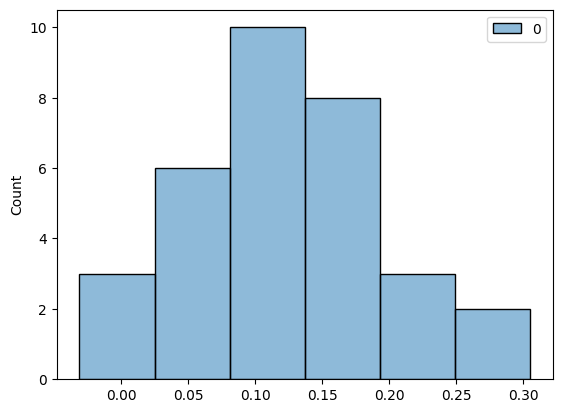

In [14]:
import seaborn as sns
sns.histplot(outputs[0].detach().numpy())

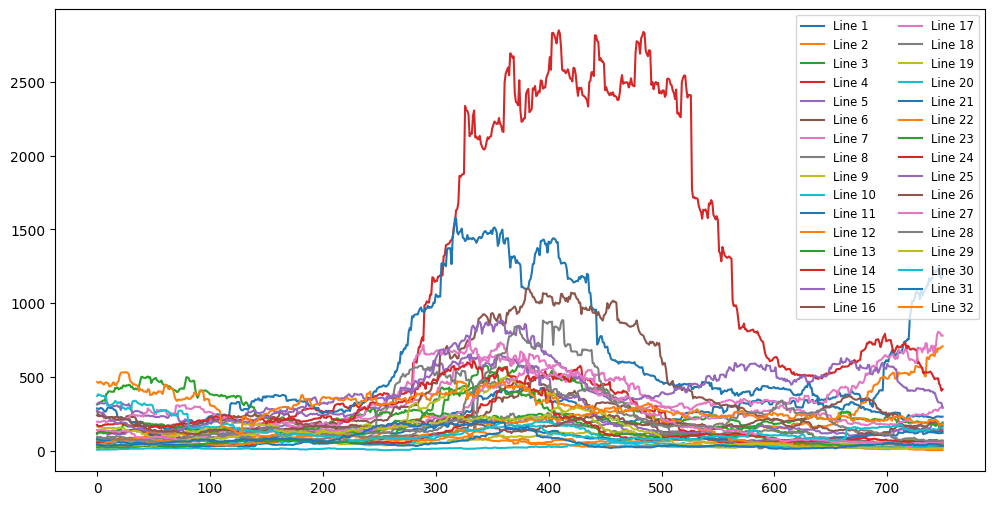

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6)) 
for i in range(targets[1].shape[0]):
    plt.plot(targets[1][i].numpy(), label=f'Line {i+1}')  # Convert tensor row to numpy for plotting
plt.legend(loc="upper right", fontsize="small", ncol=2)  # Show legend for all lines
plt.show()

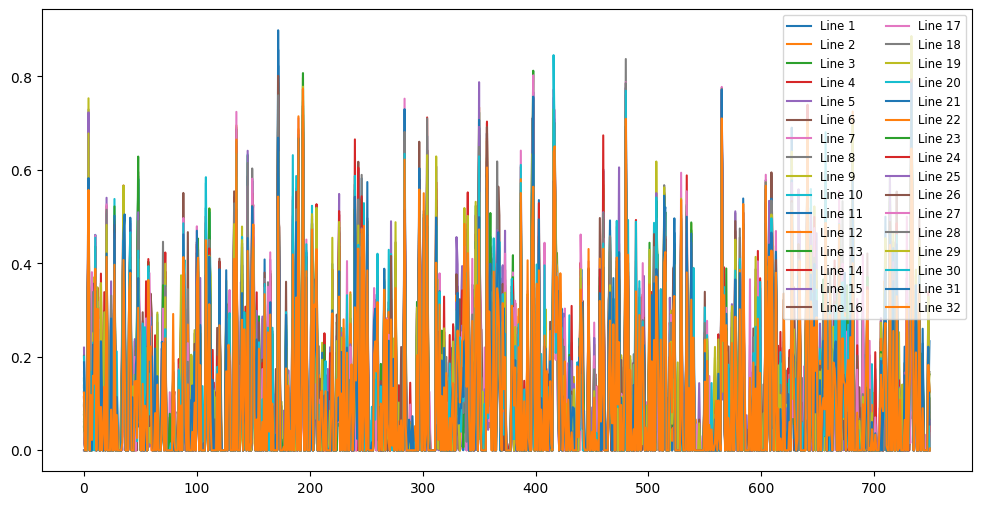

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6)) 
for i in range(outputs.shape[0]):
    plt.plot(outputs[i].detach().numpy(), label=f'Line {i+1}')  # Convert tensor row to numpy for plotting
plt.legend(loc="upper right", fontsize="small", ncol=2)  # Show legend for all lines
plt.show()

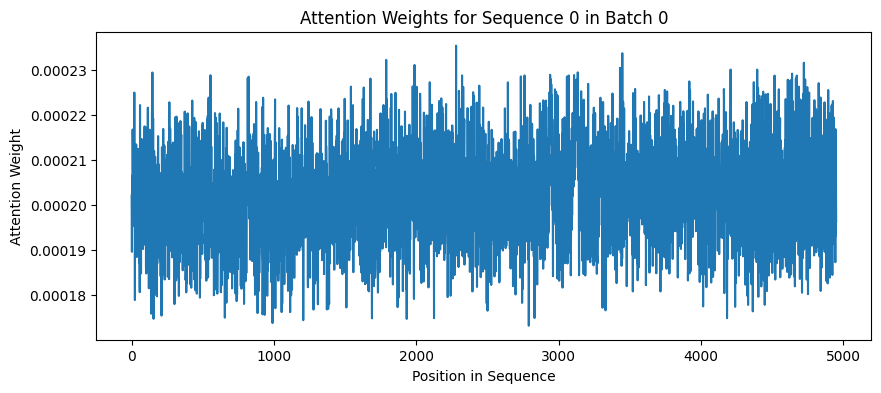

array([0.0002021 , 0.00019563, 0.00018963, ..., 0.00020902, 0.00020126,
       0.0001963 ], dtype=float32)

In [12]:
from utils import attention_utils
attention_utils.visualize_attention(trainer.model)

In [7]:
def calculate_layer_output_length(input_length, kernel_size, stride=1, padding=0, dilation=1):
    """Calculate the output length of a convolutional layer."""
    return ((input_length + 2 * padding - dilation * (kernel_size - 1) - 1) // stride) + 1

def calculate_required_input_length(desired_output_length, model_params):
    """
    Calculate the required input length to achieve a desired output length
    after all convolutions and cropping operations.
    
    Args:
        desired_output_length: The desired length of the final output
        model_params: dict containing:
            - conv1_kernel_size: Size of first convolution kernel
            - n_dil_layers: Number of dilated convolution layers
            - dilation_kernel_size: Kernel size for dilated convolutions
    
    Returns:
        required_input_length: The required input length
    """
    # Work backwards from the desired output length
    current_length = desired_output_length
    
    # First conv layer (no dilation)
    current_length = current_length + model_params['conv1_kernel_size'] - 1
    
    # Account for each dilated layer
    for i in range(model_params['n_dil_layers'], 0, -1):
        dilation = 2 ** i
        kernel_effect = (model_params['dilation_kernel_size'] - 1) * dilation
        current_length = current_length + kernel_effect

    return current_length + 2


def debug_layer_sizes(sequence_len, model_params):
    """
    Debug the size calculations for each layer of the BPNet model.
    
    Args:
        sequence_len: Initial sequence length
        model_params: dict containing model parameters
    """
    current_length = sequence_len
    print(f"\nInput sequence length: {current_length}")
    
    # First convolution
    conv1_output = calculate_layer_output_length(
        current_length,
        model_params['conv1_kernel_size'],
        padding=0
    )
    print(f"\nAfter first conv (kernel={model_params['conv1_kernel_size']}):")
    print(f"  Input: {current_length} → Output: {conv1_output}")
    print(f"  Reduction: {current_length - conv1_output}")
    
    current_length = conv1_output
    
    # Dilated convolutions
    for i in range(1, model_params['n_dil_layers'] + 1):
        dilation = 2 ** i
        dilated_field = (model_params['dilation_kernel_size'] - 1) * dilation + 1
        
        conv_output = calculate_layer_output_length(
            current_length,
            model_params['dilation_kernel_size'],
            dilation=dilation,
            padding=0
        )
        
        print(f"\nDilated conv layer {i} (dilation={dilation}, kernel={model_params['dilation_kernel_size']}):")
        print(f"  Effective receptive field: {dilated_field}")
        print(f"  Input: {current_length} → Output: {conv_output}")
        print(f"  Reduction: {current_length - conv_output}")
        
        crop_size = current_length - conv_output
        print(f"  Crop per side: {crop_size // 2}")
        
        current_length = conv_output
    
    return current_length

def verify_size_calculations(input_length, output_length, model_params):
    """
    Verify if the size calculations are correct by checking if:
    1. Forward calculation from input_length reaches output_length
    2. Backward calculation from output_length reaches input_length
    """
    print("\nVERIFICATION OF SIZE CALCULATIONS")
    print("----------------------------------")
    
    # Forward calculation
    final_length = debug_layer_sizes(input_length, model_params)
    print(f"\nForward calculation:")
    print(f"  Input length: {input_length}")
    print(f"  Calculated final length: {final_length}")
    print(f"  Target output length: {output_length}")
    print(f"  Difference from target: {final_length - output_length}")
    
    # Backward calculation
    calculated_input = calculate_required_input_length(output_length, model_params)
    print(f"\nBackward calculation:")
    print(f"  Calculated required input: {calculated_input}")
    print(f"  Actual input length: {input_length}")
    print(f"  Difference: {calculated_input - input_length}")

# Example usage
model_params = {
    'conv1_kernel_size': 21,
    'n_dil_layers': 9,
    'dilation_kernel_size': 3,
    'profile_kernel_size': 75,
}

# Test with your current sequence length and target output length
sequence_len = 2214
target_output = 500

verify_size_calculations(sequence_len, target_output, model_params)


VERIFICATION OF SIZE CALCULATIONS
----------------------------------

Input sequence length: 2214

After first conv (kernel=21):
  Input: 2214 → Output: 2194
  Reduction: 20

Dilated conv layer 1 (dilation=2, kernel=3):
  Effective receptive field: 5
  Input: 2194 → Output: 2190
  Reduction: 4
  Crop per side: 2

Dilated conv layer 2 (dilation=4, kernel=3):
  Effective receptive field: 9
  Input: 2190 → Output: 2182
  Reduction: 8
  Crop per side: 4

Dilated conv layer 3 (dilation=8, kernel=3):
  Effective receptive field: 17
  Input: 2182 → Output: 2166
  Reduction: 16
  Crop per side: 8

Dilated conv layer 4 (dilation=16, kernel=3):
  Effective receptive field: 33
  Input: 2166 → Output: 2134
  Reduction: 32
  Crop per side: 16

Dilated conv layer 5 (dilation=32, kernel=3):
  Effective receptive field: 65
  Input: 2134 → Output: 2070
  Reduction: 64
  Crop per side: 32

Dilated conv layer 6 (dilation=64, kernel=3):
  Effective receptive field: 129
  Input: 2070 → Output: 1942
  Redu